# Biosynthetic Cluster Simulator (BCS) prototype

Tyler W. H. Backman, Vincent Blay - Jan 2022

In [44]:
%matplotlib inline

In [45]:
import cobra

In [46]:
import numpy as np
from rdkit import Chem

In [47]:
import matplotlib.pyplot as plt

In [48]:
import os, sys, glob, re, pickle
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS, CHI_UNSPECIFIED, BondType, BondDir, AddHs
from rdkit.Chem.Draw import IPythonConsole
from collections import namedtuple, OrderedDict
from itertools import product
from copy import copy
from json import dumps

In [49]:
def plotMol(mol, legend='', size=600):
    display(Draw.MolsToGridImage([mol], legends=[legend], molsPerRow=1, useSVG=True, subImgSize=(size, size)))

# Database of PKS starter substrates

In [50]:
suppl = Chem.rdmolfiles.SmilesMolSupplier(
    '../bcs/data/starters.smi',
    delimiter='\t',
    titleLine=True,
    sanitize=True,
)

In [51]:
# now let's process these into a dict, and 'virtually attach to the ACP' by removal of the CoA
starters = {}

for m in suppl:
    Chem.SanitizeMol(m)
    starters[m.GetProp('_Name')] = m

In [52]:
{name: Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True) for name, mol in starters.items()}

{'Methylmalonyl-CoA': 'CC(=O)[S]',
 'butmal': 'CCCC(=O)[S]',
 'mxmal': 'COCC(=O)[S]',
 'cemal': 'CC(=O)[S]',
 'Acetyl-CoA': 'CC(=O)[S]',
 'prop': 'CCC(=O)[S]',
 'isobut': 'CC(C)C(=O)[S]',
 '2metbut': 'CCC(C)C(=O)[S]',
 'CHC-CoA': 'O=C([S])C1CCCCC1',
 'trans-1,2-CPDA': 'O=C(O)[C@@H]1CCC[C@H]1C(=O)[S]',
 'cyclopentene': 'O=C([S])C1=CCCC1=O',
 'pyr': 'O=C([S])c1ccc[nH]1',
 'cin': 'O=C([S])/C=C/c1ccccc1',
 'AHBA': 'Nc1cc(O)cc(C(=O)[S])c1',
 'isoval': 'CC(C)CC(=O)[S]',
 'PABA': 'Nc1ccc(C(=O)[S])cc1',
 'DCP': 'O=C([S])c1c[nH]c(Cl)c1Cl',
 'guan': 'NC(=[NH2+])NCC(=O)[S]',
 'mthz': 'Cc1nc(C(=O)[S])cs1',
 'DHCH': 'O=C([S])C1CC[C@@H](O)[C@H](O)C1',
 'DHCHene': 'O=C([S])C1=CC[C@@H](O)[C@H](O)C1',
 'plac': 'O=C([S])Cc1ccccc1',
 'benz': 'O=C([S])c1ccccc1',
 'PNBA': 'O=C([S])c1ccc([N+](=O)[O-])cc1',
 'ema': 'CC[C@@H](C(N)=O)C(=O)[S]',
 '3measp': 'C[C@H](N)C(=O)NC[C@H](C)C(=O)[S]'}

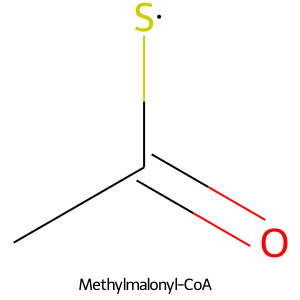

'CC(=O)[S]'

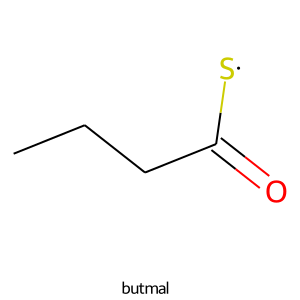

'CCCC(=O)[S]'

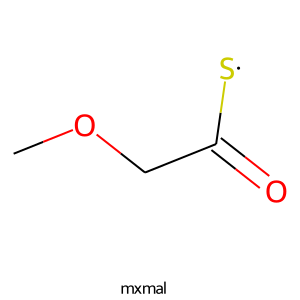

'COCC(=O)[S]'

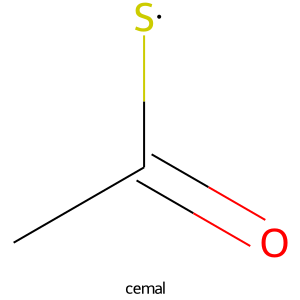

'CC(=O)[S]'

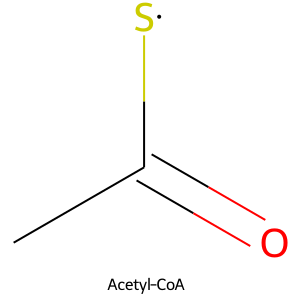

'CC(=O)[S]'

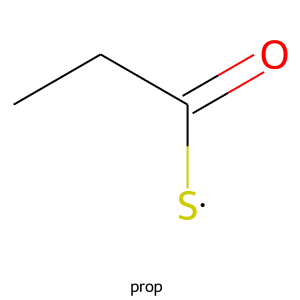

'CCC(=O)[S]'

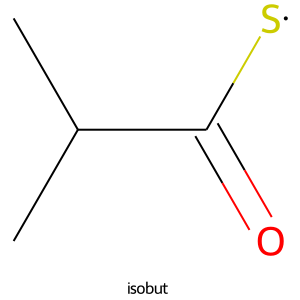

'CC(C)C(=O)[S]'

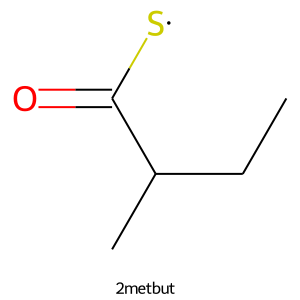

'CCC(C)C(=O)[S]'

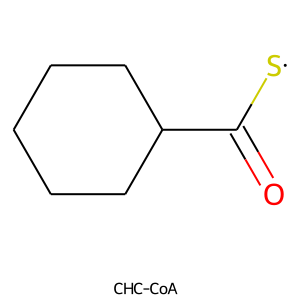

'O=C([S])C1CCCCC1'

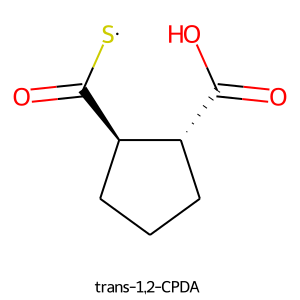

'O=C(O)[C@@H]1CCC[C@H]1C(=O)[S]'

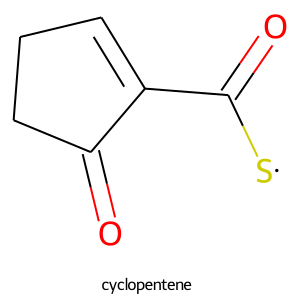

'O=C([S])C1=CCCC1=O'

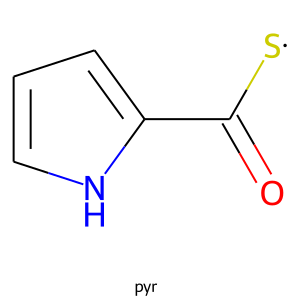

'O=C([S])c1ccc[nH]1'

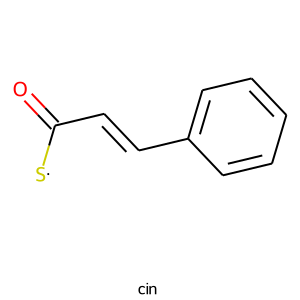

'O=C([S])/C=C/c1ccccc1'

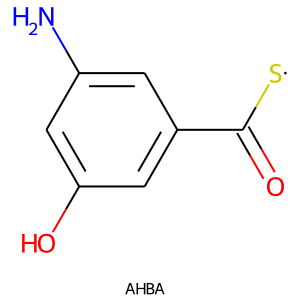

'Nc1cc(O)cc(C(=O)[S])c1'

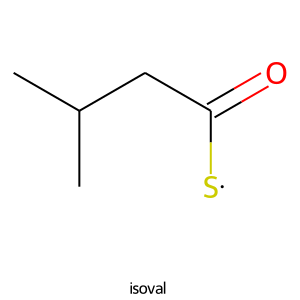

'CC(C)CC(=O)[S]'

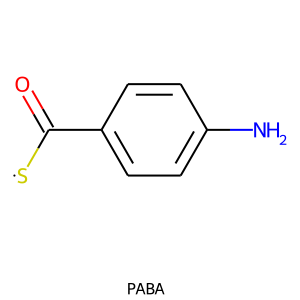

'Nc1ccc(C(=O)[S])cc1'

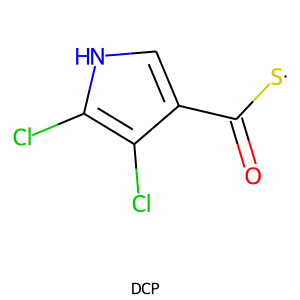

'O=C([S])c1c[nH]c(Cl)c1Cl'

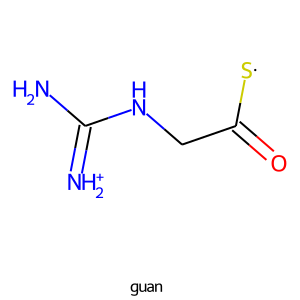

'NC(=[NH2+])NCC(=O)[S]'

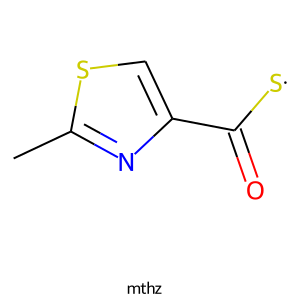

'Cc1nc(C(=O)[S])cs1'

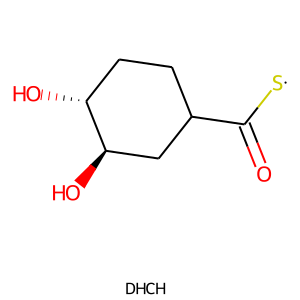

'O=C([S])C1CC[C@@H](O)[C@H](O)C1'

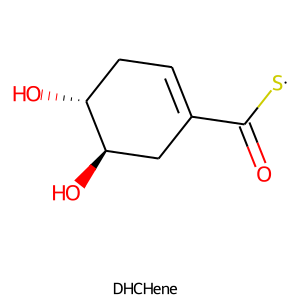

'O=C([S])C1=CC[C@@H](O)[C@H](O)C1'

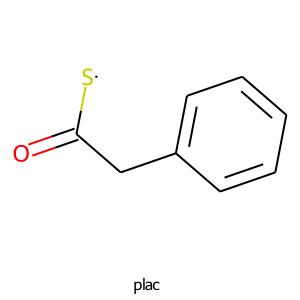

'O=C([S])Cc1ccccc1'

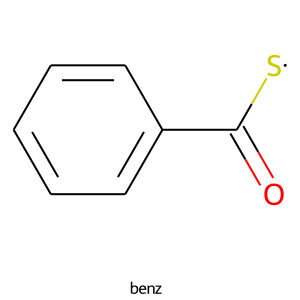

'O=C([S])c1ccccc1'

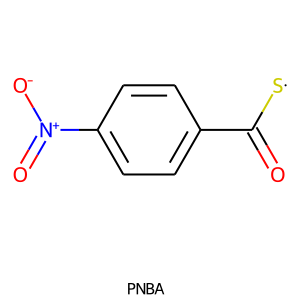

'O=C([S])c1ccc([N+](=O)[O-])cc1'

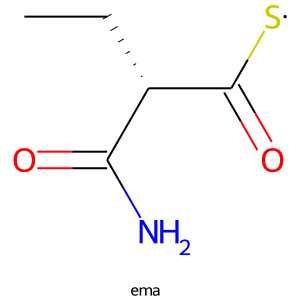

'CC[C@@H](C(N)=O)C(=O)[S]'

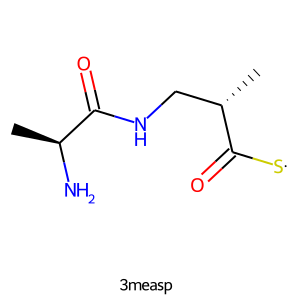

'C[C@H](N)C(=O)NC[C@H](C)C(=O)[S]'

In [53]:
# plot all structures
for name, mol in starters.items():
    plotMol(mol, name, 300)
    display(Chem.MolToSmiles(mol, isomericSmiles=True))

# Database of PKS extender substrates

How to access properties:
* m.GetProp('_Name')
* m.GetPropsAsDict()

In [54]:
extenderSuppl = Chem.rdmolfiles.SmilesMolSupplier(
    '../bcs/data/extenders.smi',
    delimiter='\t',
    titleLine=True,
    sanitize=True,
)

In [55]:
# now let's process these into a dict, and 'virtually attach to the ACP' by removal of the CoA
extenders = {}

for m in extenderSuppl:
    rxn = AllChem.ReactionFromSmarts(
        # This reaction removes the CoA
        '[O:1]=[C:2]([O:3])[C:4][C:5](=[O:6])[S:7]'
        '>>'
        '[*:10]-[C:2](=[O:1])[C:4][C:5](=[O:6])[S:7].[O:3]')
    prod = rxn.RunReactants([m])[0][0]
    Chem.SanitizeMol(prod)
    extenders[m.GetProp('_Name')] = prod

In [56]:
{name: Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True) for name, mol in extenders.items()}

{'Malonyl-CoA': '*C(=O)CC(=O)[S]',
 'Methylmalonyl-CoA': '*C(=O)[C@H](C)C(=O)[S]',
 'mxmal': '*C(=O)[C@H](OC)C(=O)[S]',
 'emal': '*C(=O)[C@H](CC)C(=O)[S]',
 'allylmal': '*C(=O)[C@H](CC=C)C(=O)[S]',
 'butmal': '*C(=O)[C@H](CCCC)C(=O)[S]',
 'hmal': '*C(=O)C(O)C(=O)[S]',
 'isobutmal': '*C(=O)[C@H](C(=O)[S])C(C)C',
 'D-isobutmal': '*C(=O)[C@@H](C(=O)[S])C(C)C',
 'DCP': '*C(=O)C(CCCCc1c[nH]c(Cl)c1Cl)C(=O)[S]',
 'hexmal': '*C(=O)[C@H](CCCCCC)C(=O)[S]'}

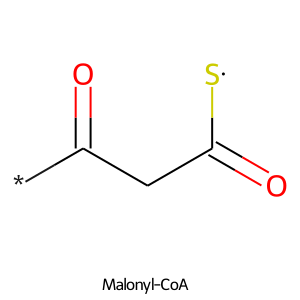

'*C(=O)CC(=O)[S]'

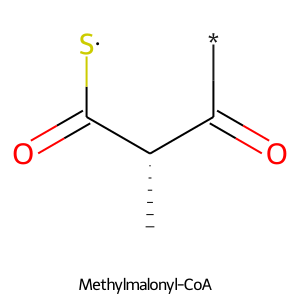

'*C(=O)[C@H](C)C(=O)[S]'

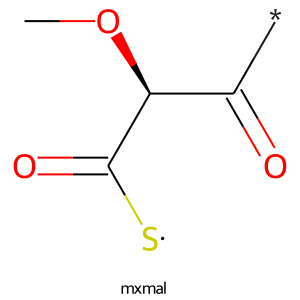

'*C(=O)[C@H](OC)C(=O)[S]'

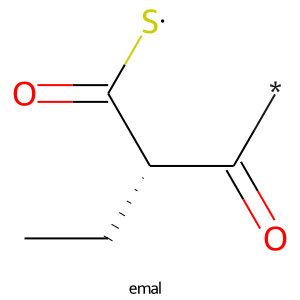

'*C(=O)[C@H](CC)C(=O)[S]'

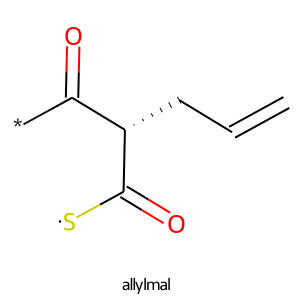

'*C(=O)[C@H](CC=C)C(=O)[S]'

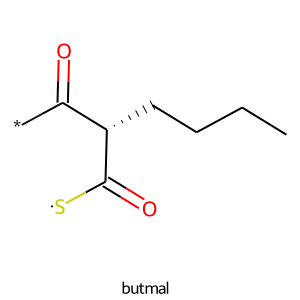

'*C(=O)[C@H](CCCC)C(=O)[S]'

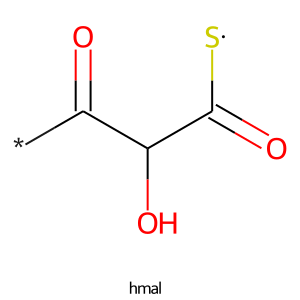

'*C(=O)C(O)C(=O)[S]'

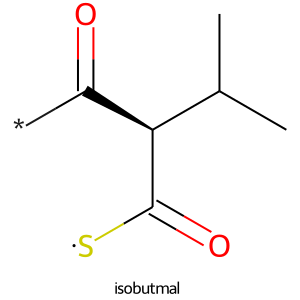

'*C(=O)[C@H](C(=O)[S])C(C)C'

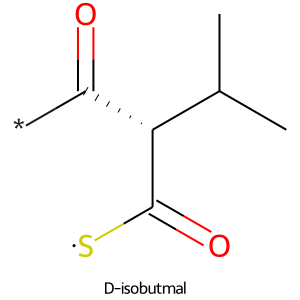

'*C(=O)[C@@H](C(=O)[S])C(C)C'

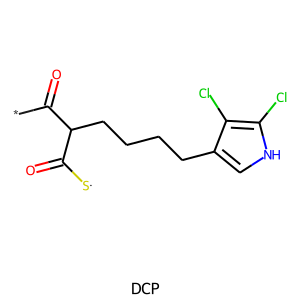

'*C(=O)C(CCCCc1c[nH]c(Cl)c1Cl)C(=O)[S]'

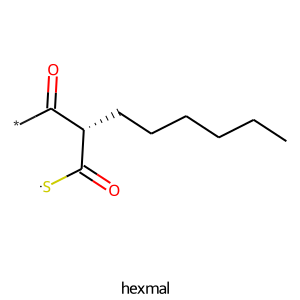

'*C(=O)[C@H](CCCCCC)C(=O)[S]'

In [57]:
# plot all structures
for name, mol in extenders.items():
    plotMol(mol, name, 300)
    display(Chem.MolToSmiles(mol, isomericSmiles=True))

# Define objects for representing PKSs

In [58]:
class Cluster:
    # Class representing a PKS design, which is just a list of modules

    def __init__(self, modules=None):
        if modules:
            self.modules = modules
        else:
            self.modules = []
            
    def computeProduct(self, structureDB, chain=False):
        '''
        This function computes the chemical product of this PKS design.
        If a mol object is passed as 'chain' only the final module operation is performed
        on this chain, and returned. This final module feature is to accelerate retrobiosynthesis.
        '''
        if chain:
            prod = chain
            modulesToExecute = [self.modules[-1]] # last module only
        else:
            prod = False
            modulesToExecute = self.modules
            
        for module in modulesToExecute:
            if TE in module.domains:
                return module.domains[TE].operation(prod)
            
            if prod:
                moduleStructure = structureDB[module]
                
                # perform condensation if this isn't in the starter
                rxn = AllChem.ReactionFromSmarts(('[#6:10][C:1](=[O:2])[S:3].'
                                 '[*:4][C:5]~[C:6]>>'
                                 '[#6:10][C:5]~[C:6]'
                                 '.[*:4].[C:1](=[O:2])[S:3]'))
                
                prod = rxn.RunReactants((prod, moduleStructure))[0][0]
                Chem.SanitizeMol(prod)
                
            else: # starter module
                # rxn = AllChem.ReactionFromSmarts(
                #    # KSQ operation - this reaction removes the * and replaces it with C
                #    '[#0:1][C:2][C:3][C:4](=[O:5])-[S:6]'
                #    '>>'
                #    '[C:3][C:4](=[O:5])-[S:6].[#0:1][C:2]')
                # assert len(moduleStructure.GetSubstructMatches(Chem.MolFromSmiles('CC(=O)S'),
                #     useChirality=True)) == 1, Chem.MolToSmiles(moduleStructure)
                # prod = rxn.RunReactants([moduleStructure])[0][0]
                # prod = moduleStructure
                prod = starters[module.domains[AT].substrate]
                
        return prod
        
class Module:
    # Class representing a PKS module
    # self.domains is an OrderedDict where keys are domain classes, 
    # and values are domain objects
    
    def __init__(self, product='', iterations=1, domains=None, loading=False):
        self.product = product
        self.iterations = iterations
        self.loading = loading
        if domains:
            self.domains = domains
        else:
            self.domains = OrderedDict()
    
    @staticmethod
    def domainTypes():
        '''
        Returns all domain types that can occur in this PKS in the catalytic order
        in which they operate.
        '''
        # return Domain.__subclasses__()
        return [AT, KR, DH, ER, TE]
    
    def computeProduct(self):
        '''
        computes the chemical product of this module
        '''
        chain = False
        for domaintype, domain in self.domains.items():
            chain = domain.operation(chain)
            
        return chain
    
    def __repr__(self):
        return repr([cls.__name__ + repr(domain) for cls, domain in self.domains.items()] + ['loading: ' + repr(self.loading)])
    
    def __hash__(self):
        # produce a unique hash key for each domain configuration
        return hash(tuple(self.domains.values()) + (self.loading,))

    def __eq__(self, other):
        if isinstance(other, type(self)):
            return hash(self) == hash(other)
        else:
            return False

    def __ne__(self, other):
        return (not self.__eq__(other))  
        
class Domain:
    # Abstract base class used to build PKS catalytic domains

    def __init__(self, active):
        '''
        Initiates a new domain with a design as reported by designSpace
        '''
        
        self.active = active
        
    def design(self):
        '''
        Reports the design of this object
        '''
        
        return vars(self)
    
    @classmethod
    def designSpace(cls, module=False):
        '''
        Returns a set of objects representing the full design space
        of this domain.
        Can optionally take a PKS module to report only the compatible
        configurations of this domain with that design. Domains of this type
        in the design are ignored. If incompatible domains are included in the
        design, it just returns an empty list.
        '''
        
        raise NotImplementedError
        
    def operation(self, chain):
        '''
        Executes this domains operation on top of an existing PKS chain as an
        RDKit mol object, and returns
        the chemical product, as well as a cobrapy reacton representing the
        stoichiometry.
        '''
        
        raise NotImplementedError        
        
    def reactants(self):
        '''
        Returns all reactants of this domain, excluding the substrate (polyketide chain).
        The format is a list of Cobrapy metabolites.
        '''
        
        raise NotImplementedError        
        
    def products(self):
        '''
        Returns all products of this domain, excluding the polyketide chain.
        The format is a list of Cobrapy metabolites.
        '''
        
        raise NotImplementedError   

    def __repr__(self):
        '''
        Returns a string representing this domain type for text based storage of
        PKS designs, or reporting to the user.
        Only prints activity if active=False to keep things concise.
        '''
        if self.active:
            designCopy = copy(self.design())
            del designCopy['active']
            return(repr(designCopy))
        else:
            return(repr(self.design()))
        
    def __hash__(self):
        # produce a unique hash key for each domain configuration
        return hash(dumps(self.design(), sort_keys=True))

    def __eq__(self, other):
        if isinstance(other, type(self)):
            return hash(self) == hash(other)
        else:
            return False

    def __ne__(self, other):
        return (not self.__eq__(other))    
        
class AT(Domain):
    
    def __init__(self, active, substrate):
        '''
        Initiates a new domain with a design as reported by designSpace
        '''
        self.active = active
        self.substrate = substrate
    
    @classmethod
    def designSpace(cls, module=False):
        if module:
            if module.loading:
                return [cls(active=True, substrate=s) for s in starters.keys()]
        
        # return only extension ATs unless passed a loading module for context
        return [cls(active=True, substrate=s) for s in extenders.keys()]
        
    def operation(self, chain, loading=False):
        if not chain:
            if loading:
                return starters[self.substrate]
            else:
                return extenders[self.substrate]
        else:
            # ATs here don't perform condensation, so need to operate first
            # the condensation is performed afterwards
            raise NotImplementedError
        
    def reactants(self):
        '''
        Returns all reactants of this domain, excluding the substrate (polyketide chain).
        The format is a list of Cobrapy metabolites.
        '''
        
        if self.substrate == 'Malonyl-CoA':
            substratecobrapy = cobra.Metabolite('malcoa_c', compartment='c')
        elif self.substrate == 'Methylmalonyl-CoA':
            substratecobrapy = cobra.Metabolite('mmcoa__S_c', compartment='c')
        else:
            substratecobrapy = cobra.Metabolite(self.substrate + '_c', compartment='c')
            
        return [
            cobra.Metabolite('h_c', compartment='c'),
            substratecobrapy
        ]      
        
    def products(self):
        '''
        Returns all products of this domain, excluding the polyketide chain.
        The format is a list of Cobrapy metabolites.
        '''
        
        return [
            cobra.Metabolite('coa_c', compartment='c'),
            cobra.Metabolite('co2_c', compartment='c')
        ]
        
        raise NotImplementedError   
            
class KR(Domain):
    TYPE_CHOICES = {'B1', 'B', 'C1'} # 2D change
    # TYPE_CHOICES = {'A1', 'A2', 'A', 'B1', 'B2', 'B', 'C1', 'C2'}
    # TYPE_CHOICES = {'A1', 'A2', 'A', 'B1', 'B2', 'B', 'C1', 'C2', 'U'}

    def __init__(self, active, type):
        '''
        Initiates a new domain with a design as reported by designSpace
        '''
        assert type in self.TYPE_CHOICES
        self.active = active
        self.type = type
        
    @classmethod
    def designSpace(cls, module=False):
        updatedTypeChoices = copy(cls.TYPE_CHOICES)
        
        if module and module.domains[AT].substrate != 'Malonyl-CoA':
            # if the domain occurs in a module WITHOUT a Malonyl-CoA AT, remove the A/B type
            updatedTypeChoices.difference_update({'A', 'B'})
        elif module:
            # if the domain occurs in a module WITH a Malonyl-CoA AT, keep only the A/B type
            updatedTypeChoices.difference_update({'A1', 'A2', 'B1', 'B2', 'C1', 'C2'})
        
        return [cls(active=True, type=type) for type in updatedTypeChoices] + [cls(active=False, type='B1')]
    
    def operation(self, chain):
        if self.type == 'A1':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C@:2]([O:3])[C@:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'A2':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C@:2]([O:3])[C@@:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'A':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C@:2]([O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'B1':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C@@:2]([O:3])[C@:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'B2':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C@@:2]([O:3])[C@@:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'B':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C@@:2]([O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'C1':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C:2](=[O:3])[C@:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        elif self.type == 'C2':
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C:2](=[O:3])[C@@:4]'
                                                   '[C:5](=[O:6])[S:7]'))
        else:
            # By first specifying some stereochemistry in the reactants
            # and then explicitly "losing" the stereochemistry in the products
            # we can forget the stereochemistry in our molecule
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C@:4]'
                                                   '[C:5](=[O:6])[S:7]>>'
                                                   '[#0:1][C:2]([O:3])[C:4]'
                                                   '[C:5](=[O:6])[S:7]'))
            
        assert len(chain.GetSubstructMatches(Chem.MolFromSmiles('C(=O)CC(=O)S'),
                   useChirality=True)) == 1, Chem.MolToSmiles(chain)
        prod = rxn.RunReactants((chain,))[0][0]
        Chem.SanitizeMol(prod)
        return prod
        
    def reactants(self):
        '''
        Returns all reactants of this domain, excluding the substrate (polyketide chain).
        The format is a list of Cobrapy metabolites.
        
        Stoich: ketone_pks_product + NADPH + H+ -> hydroxyl_pks_product + NADP+
        '''
        
        return [
            cobra.Metabolite('nadph_c', compartment='c'),
            cobra.Metabolite('h_c', compartment='c'),
        ]     
        
    def products(self):
        '''
        Returns all products of this domain, excluding the polyketide chain.
        The format is a list of Cobrapy metabolites.
        
        Stoich: ketone_pks_product + NADPH + H+ -> hydroxyl_pks_product + NADP+
        '''
        
        return [
            cobra.Metabolite('nadp_c', compartment='c'),
        ]     
    
class DH(Domain):

    @classmethod
    def designSpace(cls, module=False):
        # adding False as a design type specifies that this domain is optional,
        # e.g. a PKS can exist without it
        if not module:
            return [cls(active=True), cls(active=False)]

        if not KR in module.domains:
            return [cls(active=False)]

        # require that we have an active B/B1 KR type
        if module.domains[KR].active and (module.domains[KR].type in {'B', 'B1', 'U'}):
            return [cls(active=True), cls(active=False)]
        else:
            return [cls(active=False)]

    def operation(self, chain):
        # try setting CH unchanged
        rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2]([O:3])[C:4][C:6](=[O:7])[S:8]>>'
                                          '[#0:1][CH1:2]=[CH1:4][C:6](=[O:7])[S:8].[O:3]'))
                                          # '[#0:1][CH1:2]=[CH1:4][C:6](=[O:7])[S:8].[O:3]'))
        assert len(chain.GetSubstructMatches(Chem.MolFromSmiles('C(O)CC(=O)S'),
           useChirality=True)) == 1, Chem.MolToSmiles(chain)
        prod = rxn.RunReactants((chain,))[0][0]
        try:
            Chem.SanitizeMol(prod)
        except ValueError: 
            # if this has a methyl attached on the alpha carbon, we'll set CH0
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2]([O:3])[C:4][C:6](=[O:7])[S:8]>>'
                                              '[#0:1][CH1:2]=[CH0:4][C:6](=[O:7])[S:8].[O:3]'))
            assert len(chain.GetSubstructMatches(Chem.MolFromSmiles('C(O)CC(=O)S'),
               useChirality=True)) == 1, Chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            Chem.SanitizeMol(prod)
        return prod
        
    def reactants(self):
        '''
        Returns all reactants of this domain, excluding the substrate (polyketide chain).
        The format is a list of Cobrapy metabolites.
        
        Stoich: hydroxyl_pks_product -> alkene_pks_product + H2O
        '''
        
        return []
    
    def products(self):
        '''
        Returns all products of this domain, excluding the polyketide chain.
        The format is a list of Cobrapy metabolites.
        '''
        
        return [
            cobra.Metabolite('h2o_c', compartment='c'),
        ]    
    
class ER(Domain):
    
    @classmethod
    def designSpace(cls, module=False):
        # adding False as a design type specifies that this domain is optional,
        # e.g. a PKS can exist without it
        if not module:
            return [cls(active=True), cls(active=False)]

        if not DH in module.domains:
            return [cls(active=False)]

        # require that we have an active DH type
        if module.domains[DH].active:
            return [cls(active=True), cls(active=False)]
        else:
            return [cls(active=False)]

    def operation(self, chain):
        # try setting CH unchanged
        rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2]=[C:3][C:4](=[O:5])[S:6]>>'
                                          '[#0:1][CH2:2][CH2:3][C:4](=[O:5])[S:6]'))
                                          # '[#0:1][CH2:2][CH2:3][C:4](=[O:5])[S:6]'))
        assert len(chain.GetSubstructMatches(Chem.MolFromSmiles('C=CC(=O)S'),
           useChirality=True)) == 1, Chem.MolToSmiles(chain)
        prod = rxn.RunReactants((chain,))[0][0]
        try:
            Chem.SanitizeMol(prod)
        except ValueError: 
            rxn = AllChem.ReactionFromSmarts(('[#0:1][C:2]=[C:3][C:4](=[O:5])[S:6]>>'
                                              '[#0:1][CH2:2][C@@H1:3][C:4](=[O:5])[S:6]'))
                                              # '[#0:1][CH2:2][CH:3][C:4](=[O:5])[S:6]'))
            assert len(chain.GetSubstructMatches(Chem.MolFromSmiles('C=CC(=O)S'),
               useChirality=True)) == 1, Chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
        return prod
        
    def reactants(self):
        '''
        Returns all reactants of this domain, excluding the substrate (polyketide chain).
        The format is a list of Cobrapy metabolites.
        
        Stoich: alkene_pks_product + NADPH + H+ -> alkane_pks_product + NADP+
        '''
        
        return [
            cobra.Metabolite('nadph_c', compartment='c'),
            cobra.Metabolite('h_c', compartment='c')
        ]      
        
    def products(self):
        '''
        Returns all products of this domain, excluding the polyketide chain.
        The format is a list of Cobrapy metabolites.
        '''
        
        return [
            cobra.Metabolite('nadp_c', compartment='c')
        ]  
    
class TE(Domain):
    
    def __init__(self, active, cyclic, ring):
        '''
        Initiates a new domain with a design as reported by designSpace
        '''
        self.active = active
        self.cyclic = cyclic
        self.ring = ring

    @classmethod
    def designSpace(cls, module=False):
        # adding False as a design type specifies that this domain is optional,
        # e.g. a PKS can exist without it
        
        # For now this returns false so it doesn't get included in designs
        # later we need to deal with terminal domains in a better way
        return [cls(active=False, cyclic=False, ring=0)]

    def operation(self, chain):
        assert len(chain.GetSubstructMatches(Chem.MolFromSmiles('C(=O)S'),
                   useChirality=True)) == 1, Chem.MolToSmiles(chain)

        index = -1
        if self.cyclic:
            rxn = AllChem.ReactionFromSmarts('([C:1](=[O:2])[S:3].[O,N:4][C:5][C:6])>>'
                                                  '[C:1](=[O:2])[*:4][C:5][C:6].[S:3]')
            index -= self.ring
        else:
            rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])[S:3]>>[C:1](=[O:2])[O].[S:3]')

        # Using index -1 will yield the largest ring
        prod = rxn.RunReactants((chain,))[index][0]
        Chem.SanitizeMol(prod)

        return prod
          
    def reactants(self):
        '''
        Returns all reactants of this domain, excluding the substrate (polyketide chain).
        The format is a list of Cobrapy metabolites.
        
        Stoich: alkane_pks_product + H2O -> free_product + H+
        # NOTE: this is for non-cyclic version, we should add support for the cyclic version
        '''
        
        return [cobra.Metabolite('h2o_c', compartment='c')]        
        
    def products(self):
        '''
        Returns all products of this domain, excluding the polyketide chain.
        The format is a list of Cobrapy metabolites.
        '''
        
        return [cobra.Metabolite('h_c', compartment='c')]    


In [59]:
# show extending module AT design space
atspace = AT.designSpace(module=Module(loading=False))
atspace

[{'substrate': 'Malonyl-CoA'},
 {'substrate': 'Methylmalonyl-CoA'},
 {'substrate': 'mxmal'},
 {'substrate': 'emal'},
 {'substrate': 'allylmal'},
 {'substrate': 'butmal'},
 {'substrate': 'hmal'},
 {'substrate': 'isobutmal'},
 {'substrate': 'D-isobutmal'},
 {'substrate': 'DCP'},
 {'substrate': 'hexmal'}]

In [60]:
# show loading module AT design space
atspace = AT.designSpace(module=Module(loading=True))
atspace

[{'substrate': 'Methylmalonyl-CoA'},
 {'substrate': 'butmal'},
 {'substrate': 'mxmal'},
 {'substrate': 'cemal'},
 {'substrate': 'Acetyl-CoA'},
 {'substrate': 'prop'},
 {'substrate': 'isobut'},
 {'substrate': '2metbut'},
 {'substrate': 'CHC-CoA'},
 {'substrate': 'trans-1,2-CPDA'},
 {'substrate': 'cyclopentene'},
 {'substrate': 'pyr'},
 {'substrate': 'cin'},
 {'substrate': 'AHBA'},
 {'substrate': 'isoval'},
 {'substrate': 'PABA'},
 {'substrate': 'DCP'},
 {'substrate': 'guan'},
 {'substrate': 'mthz'},
 {'substrate': 'DHCH'},
 {'substrate': 'DHCHene'},
 {'substrate': 'plac'},
 {'substrate': 'benz'},
 {'substrate': 'PNBA'},
 {'substrate': 'ema'},
 {'substrate': '3measp'}]

In [61]:
# demonstrate hashing a domain design
hash(atspace[0])

6466811954684869359

#### perform some tests analyzing the ability to compare designs

In [62]:
# compared to a different domain, this should be False
AT(active=True, substrate='Malonyl-CoA') == AT(active=True, substrate='Methylmalonyl-CoA')

False

In [63]:
# compared to itself, this should be true
AT(active=True, substrate='Methylmalonyl-CoA') == AT(active=True, substrate='Methylmalonyl-CoA')

True

In [64]:
# two domains shouldn't be the same
atspace[0] == atspace[1]

False

# Get all possible module designs

In [65]:
# create DB of possible starter designs

starterDesigns = set()

for atdesign in AT.designSpace(module=Module(loading=True)):
    newModule = Module(loading=True)
    newModule.domains[AT] = atdesign
    
    starterDesigns.add(newModule)
    
starterDesigns

{["AT{'substrate': '2metbut'}", 'loading: True'],
 ["AT{'substrate': '3measp'}", 'loading: True'],
 ["AT{'substrate': 'AHBA'}", 'loading: True'],
 ["AT{'substrate': 'Acetyl-CoA'}", 'loading: True'],
 ["AT{'substrate': 'CHC-CoA'}", 'loading: True'],
 ["AT{'substrate': 'DCP'}", 'loading: True'],
 ["AT{'substrate': 'DHCH'}", 'loading: True'],
 ["AT{'substrate': 'DHCHene'}", 'loading: True'],
 ["AT{'substrate': 'Methylmalonyl-CoA'}", 'loading: True'],
 ["AT{'substrate': 'PABA'}", 'loading: True'],
 ["AT{'substrate': 'PNBA'}", 'loading: True'],
 ["AT{'substrate': 'benz'}", 'loading: True'],
 ["AT{'substrate': 'butmal'}", 'loading: True'],
 ["AT{'substrate': 'cemal'}", 'loading: True'],
 ["AT{'substrate': 'cin'}", 'loading: True'],
 ["AT{'substrate': 'cyclopentene'}", 'loading: True'],
 ["AT{'substrate': 'ema'}", 'loading: True'],
 ["AT{'substrate': 'guan'}", 'loading: True'],
 ["AT{'substrate': 'isobut'}", 'loading: True'],
 ["AT{'substrate': 'isoval'}", 'loading: True'],
 ["AT{'substrate':

In [66]:
# create DB of possible extension designs

# get a list of lists showing each possible domain design
domainTypes = Module.domainTypes()
allDomainDesigns = [domaintype.designSpace() for domaintype in domainTypes]

# the cartesian product of all designs specifies the full design space
fullDesignSpace = product(*allDomainDesigns)

# create a set of all possible modules
designs = set()
for design in fullDesignSpace:
        newModule = Module()
        for domain in design:
            if not domain.active:
                continue
            newModule.domains[type(domain)] = domain
            
        # check against every domain to confirm that this is a valid design
        # if a domain reports no valid configurations, this design is skipped
        try:
            for domain in newModule.domains.values():
                assert domain in domain.designSpace(newModule)
        except AssertionError:
            continue
        
        designs.add(newModule)

In [67]:
len(designs)

54

In [68]:
designs

{["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False'],
 ["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'DH{}', 'loading: False'],
 ["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'loading: False'],
 ["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'C1'}", 'loading: False'],
 ["AT{'substrate': 'D-isobutmal'}", 'loading: False'],
 ["AT{'substrate': 'DCP'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False'],
 ["AT{'substrate': 'DCP'}", "KR{'type': 'B1'}", 'DH{}', 'loading: False'],
 ["AT{'substrate': 'DCP'}", "KR{'type': 'B1'}", 'loading: False'],
 ["AT{'substrate': 'DCP'}", "KR{'type': 'C1'}", 'loading: False'],
 ["AT{'substrate': 'DCP'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'ER{}', 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", 

# Compute chemical structures of all module designs

We store this as a dict, where keys are modules, and products are mol objects representing the chemical structure

In [73]:
structureDB = {}
mols = []
legends = []
for module in designs:
    print(module)
    try:
        structureDB[module] = module.computeProduct()
        mols.append(structureDB[module])
        legends.append(repr(module))
    except IndexError:
        continue

# display(Draw.MolsToGridImage(mols, legends=legends, molsPerRow=2, useSVG=True, subImgSize=(400, 400)))

["AT{'substrate': 'butmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False']
["AT{'substrate': 'D-isobutmal'}", 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'allylmal'}", "KR{'type': 'B1'}", 'DH{}', 'loading: False']
["AT{'substrate': 'hmal'}", "KR{'type': 'C1'}", 'loading: False']
["AT{'substrate': 'D-isobutmal'}", "KR{'type': 'B1'}", 'DH{}', 'loading: False']
["AT{'substrate': 'mxmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", 'loading: False']
["AT{'substrate': 'allylmal'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substrate': 'allylmal'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'DH{}', 'loading: False']
["AT{'substrate': 'isobutmal'}", "KR{'type': 'C1'}", 'loading: False']
["AT{'substrate': 'hexmal'}", "KR{'type': 'B1'}", 'loading: False']
["AT{'substra

In [74]:
import rdkit
rdkit.__version__

'2020.09.4'

In [75]:
for mol, legend in zip(mols, legends):
    display(legend)
    display(Chem.MolToSmiles(mol, isomericSmiles=True))

'["AT{\'substrate\': \'butmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](CCCC)C(=O)S'

'["AT{\'substrate\': \'D-isobutmal\'}", \'loading: False\']'

'*C(=O)[C@@H](C(=O)[S])C(C)C'

'["AT{\'substrate\': \'isobutmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@H](C(=O)[S])C(C)C'

'["AT{\'substrate\': \'allylmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(CC=C)C(=O)[S]'

'["AT{\'substrate\': \'hmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](O)C(=O)[S]'

'["AT{\'substrate\': \'D-isobutmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(C(=O)[S])C(C)C'

'["AT{\'substrate\': \'mxmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](OC)C(=O)S'

'["AT{\'substrate\': \'Malonyl-CoA\'}", \'loading: False\']'

'*C(=O)CC(=O)[S]'

'["AT{\'substrate\': \'allylmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](CC=C)C(=O)[S]'

'["AT{\'substrate\': \'Methylmalonyl-CoA\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](C)C(=O)[S]'

'["AT{\'substrate\': \'allylmal\'}", \'loading: False\']'

'*C(=O)[C@H](CC=C)C(=O)[S]'

'["AT{\'substrate\': \'Malonyl-CoA\'}", "KR{\'type\': \'B\'}", \'DH{}\', \'loading: False\']'

'*C=CC(=O)[S]'

'["AT{\'substrate\': \'isobutmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@H](C(=O)[S])C(C)C'

'["AT{\'substrate\': \'hexmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](CCCCCC)C(=O)[S]'

'["AT{\'substrate\': \'allylmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](CC=C)C(=O)[S]'

'["AT{\'substrate\': \'Malonyl-CoA\'}", "KR{\'type\': \'B\'}", \'loading: False\']'

'*[C@@H](O)CC(=O)[S]'

'["AT{\'substrate\': \'emal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](CC)C(=O)[S]'

'["AT{\'substrate\': \'hexmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(CCCCCC)C(=O)[S]'

'["AT{\'substrate\': \'D-isobutmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@H](C(=O)[S])C(C)C'

'["AT{\'substrate\': \'butmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](CCCC)C(=O)[S]'

'["AT{\'substrate\': \'emal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(CC)C(=O)[S]'

'["AT{\'substrate\': \'hmal\'}", \'loading: False\']'

'*C(=O)C(O)C(=O)[S]'

'["AT{\'substrate\': \'hexmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](CCCCCC)C(=O)[S]'

'["AT{\'substrate\': \'emal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](CC)C(=O)[S]'

'["AT{\'substrate\': \'emal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](CC)C(=O)S'

'["AT{\'substrate\': \'Methylmalonyl-CoA\'}", \'loading: False\']'

'*C(=O)[C@H](C)C(=O)[S]'

'["AT{\'substrate\': \'butmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](CCCC)C(=O)[S]'

'["AT{\'substrate\': \'Methylmalonyl-CoA\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](C)C(=O)[S]'

'["AT{\'substrate\': \'DCP\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(CCCCc1c[nH]c(Cl)c1Cl)C(=O)[S]'

'["AT{\'substrate\': \'hexmal\'}", \'loading: False\']'

'*C(=O)[C@H](CCCCCC)C(=O)[S]'

'["AT{\'substrate\': \'hexmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](CCCCCC)C(=O)S'

'["AT{\'substrate\': \'D-isobutmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@H](C(=O)[S])C(C)C'

'["AT{\'substrate\': \'Malonyl-CoA\'}", "KR{\'type\': \'B\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*CCC(=O)[S]'

'["AT{\'substrate\': \'DCP\'}", \'loading: False\']'

'*C(=O)C(CCCCc1c[nH]c(Cl)c1Cl)C(=O)[S]'

'["AT{\'substrate\': \'isobutmal\'}", \'loading: False\']'

'*C(=O)[C@H](C(=O)[S])C(C)C'

'["AT{\'substrate\': \'mxmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](OC)C(=O)[S]'

'["AT{\'substrate\': \'emal\'}", \'loading: False\']'

'*C(=O)[C@H](CC)C(=O)[S]'

'["AT{\'substrate\': \'Methylmalonyl-CoA\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(C)C(=O)[S]'

'["AT{\'substrate\': \'butmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(CCCC)C(=O)[S]'

'["AT{\'substrate\': \'isobutmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(C(=O)[S])C(C)C'

'["AT{\'substrate\': \'butmal\'}", \'loading: False\']'

'*C(=O)[C@H](CCCC)C(=O)[S]'

'["AT{\'substrate\': \'mxmal\'}", \'loading: False\']'

'*C(=O)[C@H](OC)C(=O)[S]'

'["AT{\'substrate\': \'isobutmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@@H](C(=O)S)C(C)C'

'["AT{\'substrate\': \'DCP\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](CCCCc1c[nH]c(Cl)c1Cl)C(=O)[S]'

'["AT{\'substrate\': \'hmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](O)C(=O)S'

'["AT{\'substrate\': \'DCP\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](CCCCc1c[nH]c(Cl)c1Cl)C(=O)S'

'["AT{\'substrate\': \'mxmal\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](OC)C(=O)[S]'

'["AT{\'substrate\': \'mxmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(OC)C(=O)[S]'

'["AT{\'substrate\': \'hmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'loading: False\']'

'*C=C(O)C(=O)[S]'

'["AT{\'substrate\': \'DCP\'}", "KR{\'type\': \'C1\'}", \'loading: False\']'

'*C(=O)[C@@H](CCCCc1c[nH]c(Cl)c1Cl)C(=O)[S]'

'["AT{\'substrate\': \'D-isobutmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@@H](C(=O)S)C(C)C'

'["AT{\'substrate\': \'Methylmalonyl-CoA\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](C)C(=O)S'

'["AT{\'substrate\': \'allylmal\'}", "KR{\'type\': \'B1\'}", \'DH{}\', \'ER{}\', \'loading: False\']'

'*C[C@H](CC=C)C(=O)S'

'["AT{\'substrate\': \'hmal\'}", "KR{\'type\': \'B1\'}", \'loading: False\']'

'*[C@@H](O)[C@@H](O)C(=O)[S]'

# Demonstrate condensation to build a multi-module PKS

In [76]:
AT.designSpace(module=Module(loading=True))

[{'substrate': 'Methylmalonyl-CoA'},
 {'substrate': 'butmal'},
 {'substrate': 'mxmal'},
 {'substrate': 'cemal'},
 {'substrate': 'Acetyl-CoA'},
 {'substrate': 'prop'},
 {'substrate': 'isobut'},
 {'substrate': '2metbut'},
 {'substrate': 'CHC-CoA'},
 {'substrate': 'trans-1,2-CPDA'},
 {'substrate': 'cyclopentene'},
 {'substrate': 'pyr'},
 {'substrate': 'cin'},
 {'substrate': 'AHBA'},
 {'substrate': 'isoval'},
 {'substrate': 'PABA'},
 {'substrate': 'DCP'},
 {'substrate': 'guan'},
 {'substrate': 'mthz'},
 {'substrate': 'DHCH'},
 {'substrate': 'DHCHene'},
 {'substrate': 'plac'},
 {'substrate': 'benz'},
 {'substrate': 'PNBA'},
 {'substrate': 'ema'},
 {'substrate': '3measp'}]

In [77]:
starter = Module(domains={AT: AT.designSpace(module=Module(loading=True))[12]}, loading=True)

In [78]:
allModuleTypes = list(designs)
newCluster = Cluster([starter, allModuleTypes[0], allModuleTypes[0], allModuleTypes[8]])

In [79]:
newCluster.modules

[["AT{'substrate': 'cin'}", 'loading: True'],
 ["AT{'substrate': 'butmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False'],
 ["AT{'substrate': 'butmal'}", "KR{'type': 'B1'}", 'DH{}', 'ER{}', 'loading: False'],
 ["AT{'substrate': 'allylmal'}", "KR{'type': 'B1'}", 'loading: False']]

Wall time: 11 ms


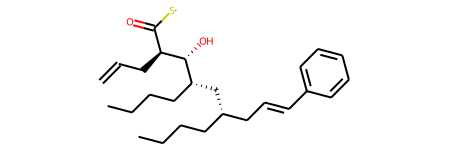

In [80]:
%%time
newCluster.computeProduct(structureDB)